In [1]:
%load_ext autoreload
%autoreload 2
from Methods import JobOffers,dataframeHelpers

In [2]:
import os
import nltk
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [3]:
autoreload JobOffers,dataframeHelpers

In [4]:
# Only run this if you want to redo the translations
# Start with google and use easynmt if it fails
# JobOffers.writeTranslatedJobs(1000, method="google", fallback=True)

In [5]:
# rawOffers = JobOffers.readJsonFile("Data/output_v1.1.json")

In [6]:
mergedDf = pd.read_csv("mergedJobs1000.csv")

In [7]:
for canton in mergedDf["CANTON1"].value_counts().index[:-1]:
    mergedDf[f"Canton_{canton}"] = mergedDf.apply(lambda x: canton in x["CANTON"], axis=1)

In [8]:
dummies = pd.get_dummies(mergedDf["COMPANY_SIZE"])
mergedDf = mergedDf.join(dummies)

In [9]:
mergedDf

,Unnamed: 0,index,JOB_ID,MJ,ISCO,JOB_CONTENT,TRANSLATED_JOBS,CANTON,COMPANY_SIZE,CANTON1,...,Canton_GE,Canton_NE,Canton_FR,Canton_VS,Canton_JU,Canton_AR,Large,Micro,Midsize,Small
0,0,0,12047533.0,1,31230;12190;21620,['Building leaders Horticultural technician HF...,Building leaders Horticultural technician HF T...,['BE'],Micro,BE,...,False,False,False,False,False,False,0,1,0,0
1,1,1,14422389.0,1,21620,['As an educational and social education cente...,"As an educational and social education center,...",['BE'],Small,BE,...,False,False,False,False,False,False,0,0,0,1
2,2,2,14616465.0,1,21420,['Civil Engineer 1804 Corsiersurvey Engineerin...,Civil Engineer 1804 Corsiersurvey Engineering ...,['VD'],Micro,VD,...,False,False,False,False,False,False,0,1,0,0
3,3,3,14617343.0,1,21620,"['24', ' 05', ' 2017 Internship Landscape Deve...",24. 05. 2017 Internship Landscape Development ...,['BE'],Micro,BE,...,False,False,False,False,False,False,0,1,0,0
4,4,4,14515774.0,1,21430,['Company portrait The office for the forest o...,Company portrait The office for the forest of ...,['BE'],Midsize,BE,...,False,False,False,False,False,False,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,1120,120,20933760.0,1,24310;24210,"[""Emploi ESDA is looking for a Market Data Ana...",Emploi ESDA is looking for a Market Data Analy...,['GE'],Midsize,GE,...,True,False,False,False,False,False,0,0,1,0
1121,1121,121,21930428.0,1,26220;41200,"['Org', ' Setting and Reporting This position...",Org. Setting and Reporting This position is l...,['GE'],Midsize,GE,...,True,False,False,False,False,False,0,0,1,0
1122,1122,122,22071257.0,1,26220,['Caterpillar Graduate Program Junior Busines...,Caterpillar Graduate Program Junior Business ...,['GE'],Large,GE,...,True,False,False,False,False,False,1,0,0,0
1123,1123,123,18359929.0,1,21490,"['Energy Energy Management Raymond E', ' Moser...",Energy Energy Management Raymond E. Moser has ...,['GE'],Micro,GE,...,True,False,False,False,False,False,0,1,0,0


In [10]:
mergedDf["MJ"].value_counts()

1        304
0        221
False     16
Name: MJ, dtype: int64

In [11]:
labeledDf = mergedDf[~mergedDf["MJ"].isna()]

In [12]:
labeledDf

,Unnamed: 0,index,JOB_ID,MJ,ISCO,JOB_CONTENT,TRANSLATED_JOBS,CANTON,COMPANY_SIZE,CANTON1,...,Canton_GE,Canton_NE,Canton_FR,Canton_VS,Canton_JU,Canton_AR,Large,Micro,Midsize,Small
0,0,0,12047533.0,1,31230;12190;21620,['Building leaders Horticultural technician HF...,Building leaders Horticultural technician HF T...,['BE'],Micro,BE,...,False,False,False,False,False,False,0,1,0,0
1,1,1,14422389.0,1,21620,['As an educational and social education cente...,"As an educational and social education center,...",['BE'],Small,BE,...,False,False,False,False,False,False,0,0,0,1
2,2,2,14616465.0,1,21420,['Civil Engineer 1804 Corsiersurvey Engineerin...,Civil Engineer 1804 Corsiersurvey Engineering ...,['VD'],Micro,VD,...,False,False,False,False,False,False,0,1,0,0
3,3,3,14617343.0,1,21620,"['24', ' 05', ' 2017 Internship Landscape Deve...",24. 05. 2017 Internship Landscape Development ...,['BE'],Micro,BE,...,False,False,False,False,False,False,0,1,0,0
4,4,4,14515774.0,1,21430,['Company portrait The office for the forest o...,Company portrait The office for the forest of ...,['BE'],Midsize,BE,...,False,False,False,False,False,False,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,1120,120,20933760.0,1,24310;24210,"[""Emploi ESDA is looking for a Market Data Ana...",Emploi ESDA is looking for a Market Data Analy...,['GE'],Midsize,GE,...,True,False,False,False,False,False,0,0,1,0
1121,1121,121,21930428.0,1,26220;41200,"['Org', ' Setting and Reporting This position...",Org. Setting and Reporting This position is l...,['GE'],Midsize,GE,...,True,False,False,False,False,False,0,0,1,0
1122,1122,122,22071257.0,1,26220,['Caterpillar Graduate Program Junior Busines...,Caterpillar Graduate Program Junior Business ...,['GE'],Large,GE,...,True,False,False,False,False,False,1,0,0,0
1123,1123,123,18359929.0,1,21490,"['Energy Energy Management Raymond E', ' Moser...",Energy Energy Management Raymond E. Moser has ...,['GE'],Micro,GE,...,True,False,False,False,False,False,0,1,0,0


In [13]:
mergedDf

,Unnamed: 0,index,JOB_ID,MJ,ISCO,JOB_CONTENT,TRANSLATED_JOBS,CANTON,COMPANY_SIZE,CANTON1,...,Canton_GE,Canton_NE,Canton_FR,Canton_VS,Canton_JU,Canton_AR,Large,Micro,Midsize,Small
0,0,0,12047533.0,1,31230;12190;21620,['Building leaders Horticultural technician HF...,Building leaders Horticultural technician HF T...,['BE'],Micro,BE,...,False,False,False,False,False,False,0,1,0,0
1,1,1,14422389.0,1,21620,['As an educational and social education cente...,"As an educational and social education center,...",['BE'],Small,BE,...,False,False,False,False,False,False,0,0,0,1
2,2,2,14616465.0,1,21420,['Civil Engineer 1804 Corsiersurvey Engineerin...,Civil Engineer 1804 Corsiersurvey Engineering ...,['VD'],Micro,VD,...,False,False,False,False,False,False,0,1,0,0
3,3,3,14617343.0,1,21620,"['24', ' 05', ' 2017 Internship Landscape Deve...",24. 05. 2017 Internship Landscape Development ...,['BE'],Micro,BE,...,False,False,False,False,False,False,0,1,0,0
4,4,4,14515774.0,1,21430,['Company portrait The office for the forest o...,Company portrait The office for the forest of ...,['BE'],Midsize,BE,...,False,False,False,False,False,False,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,1120,120,20933760.0,1,24310;24210,"[""Emploi ESDA is looking for a Market Data Ana...",Emploi ESDA is looking for a Market Data Analy...,['GE'],Midsize,GE,...,True,False,False,False,False,False,0,0,1,0
1121,1121,121,21930428.0,1,26220;41200,"['Org', ' Setting and Reporting This position...",Org. Setting and Reporting This position is l...,['GE'],Midsize,GE,...,True,False,False,False,False,False,0,0,1,0
1122,1122,122,22071257.0,1,26220,['Caterpillar Graduate Program Junior Busines...,Caterpillar Graduate Program Junior Business ...,['GE'],Large,GE,...,True,False,False,False,False,False,1,0,0,0
1123,1123,123,18359929.0,1,21490,"['Energy Energy Management Raymond E', ' Moser...",Energy Energy Management Raymond E. Moser has ...,['GE'],Micro,GE,...,True,False,False,False,False,False,0,1,0,0


In [14]:
labeledDf["MJ"].astype('bool').value_counts()

True    541
Name: MJ, dtype: int64

In [15]:
# Only take 2/3 of the "not green" jobs so you have a balanced data set
trainDf = labeledDf[labeledDf.index % 3 != 0]

In [16]:
testDf = labeledDf[labeledDf.index % 3 == 0]

In [17]:
from tensorflow.keras.utils import plot_model

In [18]:
def buildInputs(df):
    normSent = (df["NumSentences"]-df["NumSentences"].mean())/df["NumSentences"].std()
    normChar = (df["NumCharacters"]-df["NumCharacters"].mean())/df["NumCharacters"].std()
    return np.stack(
        (
            normSent, 
            normChar,
            df["Canton_BE"],
            df["Canton_VD"],
            df["Canton_NE"],
            df["Canton_FR"], 
            df["Canton_GE"],
            df["Canton_VS"],
            df["Canton_JU"],
            df["Large"],
            df["Micro"], 
            df["Midsize"],
            df["Small"],
        ), axis=-1)  

In [19]:
inputs = buildInputs(trainDf)
tf.keras.backend.clear_session()

In [20]:
paragraphInput = tf.keras.layers.Input(shape=(), name="Input", dtype=tf.string)
paragraphEncode = hub.KerasLayer('universal-sentence-encoder_4',
                        input_shape=[], 
                        dtype=tf.string, 
                        trainable=True)(paragraphInput)


In [21]:
paragraphDense = tf.keras.layers.Dense(256, activation='relu')(paragraphEncode)

In [22]:
otherInput = tf.keras.layers.Input(shape=(inputs.shape[1],))
otherDense = tf.keras.layers.Dense(16,)(otherInput)
mergedLayer = tf.keras.layers.Concatenate()([otherDense, paragraphDense])
denseMerged = tf.keras.layers.Dense(32, activation='relu')(mergedLayer)
output = tf.keras.layers.Dense(1, activation='sigmoid')(denseMerged)

In [23]:
model = tf.keras.Model(inputs=[paragraphInput, otherInput], outputs=output)
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [24]:
testDf["TRANSLATED_JOBS"]

0       Building leaders Horticultural technician HF T...
3       24. 05. 2017 Internship Landscape Development ...
6       As an educational and social education center,...
9       The ROSSIER SA design office is an official of...
12      To reinforce our group of companies, we are lo...
                              ...                        
1110    The Ecole polytechnique fédérale de Lausanne E...
1113    Climate Strategy Lead  Switzerland Why youll l...
1116    Renowned business in the field of renewable en...
1119    Basic Data Manager HF Introduction For our Div...
1122    Caterpillar Graduate Program  Junior Business ...
Name: TRANSLATED_JOBS, Length: 180, dtype: object

In [34]:
model.fit(x=[trainDf["TRANSLATED_JOBS"], inputs], 
          y=trainDf["MJ"].astype("bool"), 
          validation_data=([testDf["TRANSLATED_JOBS"], buildInputs(testDf)], testDf["MJ"].astype("bool")),
          epochs=5)

Epoch 1/5
12/12 [==============================] - 25s 2s/step - loss: 1.2745e-04 - accuracy: 1.0000 - val_loss: 9.0351e-05 - val_accuracy: 1.0000
Epoch 2/5
12/12 [==============================] - 22s 2s/step - loss: 7.9161e-05 - accuracy: 1.0000 - val_loss: 6.9296e-05 - val_accuracy: 1.0000
Epoch 3/5
12/12 [==============================] - 26s 2s/step - loss: 6.5140e-05 - accuracy: 1.0000 - val_loss: 6.1106e-05 - val_accuracy: 1.0000
Epoch 4/5
12/12 [==============================] - 27s 2s/step - loss: 5.8829e-05 - accuracy: 1.0000 - val_loss: 5.6472e-05 - val_accuracy: 1.0000
Epoch 5/5
12/12 [==============================] - 24s 2s/step - loss: 5.4820e-05 - accuracy: 1.0000 - val_loss: 5.2955e-05 - val_accuracy: 1.0000


In [35]:
testInputs = buildInputs(testDf)
testDf["GREEN_PREDICT_FULL"] = model.predict(x=[testDf["TRANSLATED_JOBS"], testInputs]) > 0.5

<ipython-input-35-45a9bef92dad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testDf["GREEN_PREDICT_FULL"] = model.predict(x=[testDf["TRANSLATED_JOBS"], testInputs]) > 0.5


In [36]:
confusion = pd.crosstab([testDf["MJ"].astype('bool'), testDf["GREEN_PREDICT_FULL"]], columns=["MJ", "GREEN_PREDICT"])

In [37]:
confusion

,col_0,MJ
,col_1,GREEN_PREDICT
MJ,GREEN_PREDICT_FULL,
True,True,180


In [38]:
import seaborn as sn


<AxesSubplot:xlabel='col_0-col_1', ylabel='MJ-GREEN_PREDICT_FULL'>

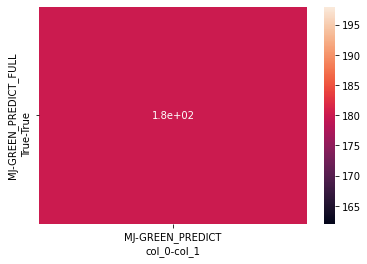

In [39]:
sn.heatmap(confusion, annot=True, )

In [ ]:
plot_model(model, to_file='Plots/NeuralNetArch_AllInputs.pdf', show_shapes=True, show_layer_names=True)

In [40]:
testDf["MJ"].astype('bool').value_counts()

True    180
Name: MJ, dtype: int64

In [41]:
denseUnmerged = tf.keras.layers.Dense(32, activation='relu')(paragraphDense)
outputUnmerged = tf.keras.layers.Dense(1, activation='sigmoid')(denseUnmerged)

In [42]:
simpleModel = tf.keras.Model(inputs=[paragraphInput], outputs=outputUnmerged)
simpleModel.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [43]:
simpleModel.fit(x=[trainDf["TRANSLATED_JOBS"]], 
          y=trainDf["MJ"].astype('bool'), 
          validation_data=(testDf["TRANSLATED_JOBS"], testDf["MJ"].astype('bool')),
          epochs=6)

Epoch 1/6
12/12 [==============================] - 27s 2s/step - loss: 0.1337 - accuracy: 1.0000 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 2/6
12/12 [==============================] - 24s 2s/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 3/6
12/12 [==============================] - 27s 2s/step - loss: 9.4063e-04 - accuracy: 1.0000 - val_loss: 5.9911e-04 - val_accuracy: 1.0000
Epoch 4/6
12/12 [==============================] - 28s 2s/step - loss: 4.9744e-04 - accuracy: 1.0000 - val_loss: 4.0437e-04 - val_accuracy: 1.0000
Epoch 5/6
12/12 [==============================] - 22s 2s/step - loss: 3.6419e-04 - accuracy: 1.0000 - val_loss: 3.2165e-04 - val_accuracy: 1.0000
Epoch 6/6
12/12 [==============================] - 22s 2s/step - loss: 2.9750e-04 - accuracy: 1.0000 - val_loss: 2.6941e-04 - val_accuracy: 1.0000


In [ ]:
plot_model(simpleModel, to_file='Plots/NeuralNetArch_OnlySentences.pdf', show_shapes=True, show_layer_names=True)

In [44]:
testInputs = buildInputs(testDf)
testDf["GREEN_PREDICT_SIMPLE"] = model.predict(x=[testDf["TRANSLATED_JOBS"], testInputs]) > 0.5
confusionSimple = pd.crosstab([testDf["MJ"].astype('bool'), testDf["GREEN_PREDICT_SIMPLE"]], columns=["MJ", "GREEN_PREDICT"])

<ipython-input-44-fa8b21165679>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testDf["GREEN_PREDICT_SIMPLE"] = model.predict(x=[testDf["TRANSLATED_JOBS"], testInputs]) > 0.5


In [45]:
confusionSimple 

,col_0,MJ
,col_1,GREEN_PREDICT
MJ,GREEN_PREDICT_SIMPLE,
True,True,180


In [ ]:
testDf["GREEN_PREDICT"].value_counts()

In [ ]:
validInputs = buildInputs(mergedDf)

In [ ]:
mergedDf["GREEN_PREDICT"] = model.predict(x=[mergedDf["TRANSLATED_JOBS"], validInputs]) > 0.5

In [ ]:
len(mergedDf[(mergedDf["GREEN_PREDICT"] != mergedDf["MJ"]) & ~mergedDf["MJ"].isna()])/len(mergedDf)